# Detecting patterns of speciation in the fos- sil record

In this assignment, we use data from the NOW (New and Old Worlds) database of fossil mammals to study patterns of speciation over time and space. In particular, we are interested to know when and where speciation rates have been significantly high. The task is to find which time periods and which places over the history of mammals have given rise to exceptionally high numbers of new species. The phenomenon is known in the evolutionary literature as the “species factory”. Palaeontologists are interested why and in which ways those times and places are special. The role of computational science is to identify and characterize such times and places.
We practice using pandas DataFrames, performing logistic regression and making statistical significance tests in data analysis.

/var/folders/ty/bb1nmsps28q18g1t_w7bn9080000gn/T/ipykernel_3102/3103600944.py:167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df.drop_duplicates(subset=['LIDNUM'], keep="first", inplace=True) # leaving only unique LIDNUM values, now result_df has the same length as all_occ
/var/folders/ty/bb1nmsps28q18g1t_w7bn9080000gn/T/ipykernel_3102/3103600944.py:169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df["FIRST_OCC"] = result_df["LIDNUM"].map(first_occ_dict)
/var/folders/ty/bb1nmsps28q18g1t_w7bn9080000gn/T/ipykernel_3102/3103600944.py:170: SettingW

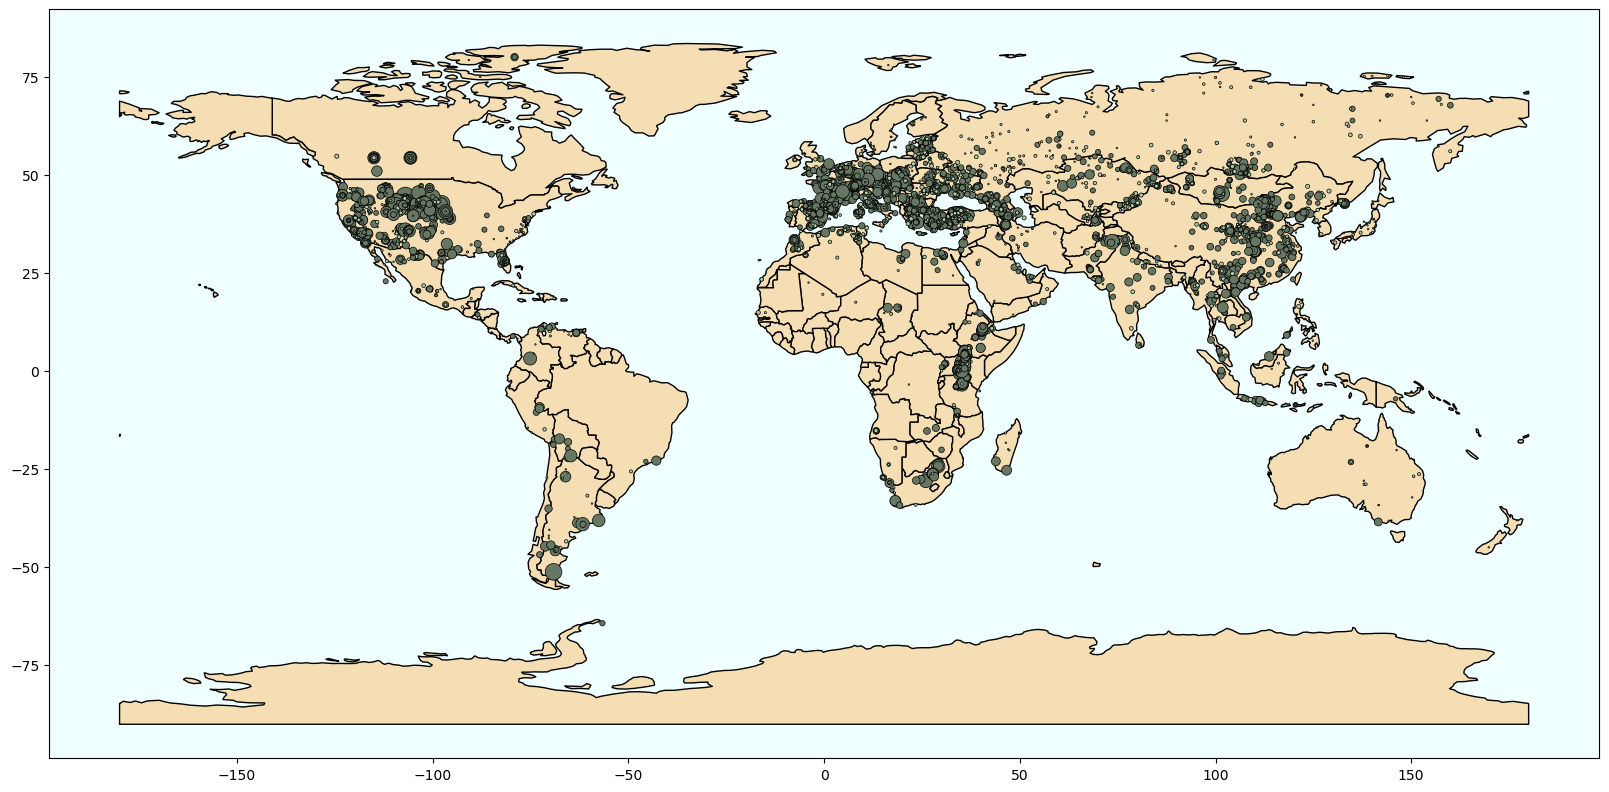

Optimization terminated successfully.
         Current function value: 0.484414
         Iterations 6


/var/folders/ty/bb1nmsps28q18g1t_w7bn9080000gn/T/ipykernel_3102/3103600944.py:262: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = (geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))) # loading the world map


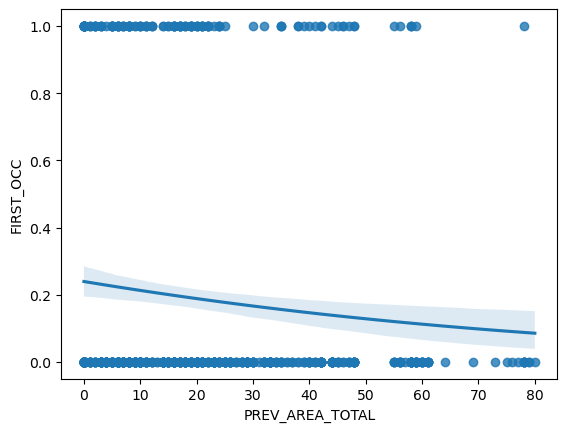

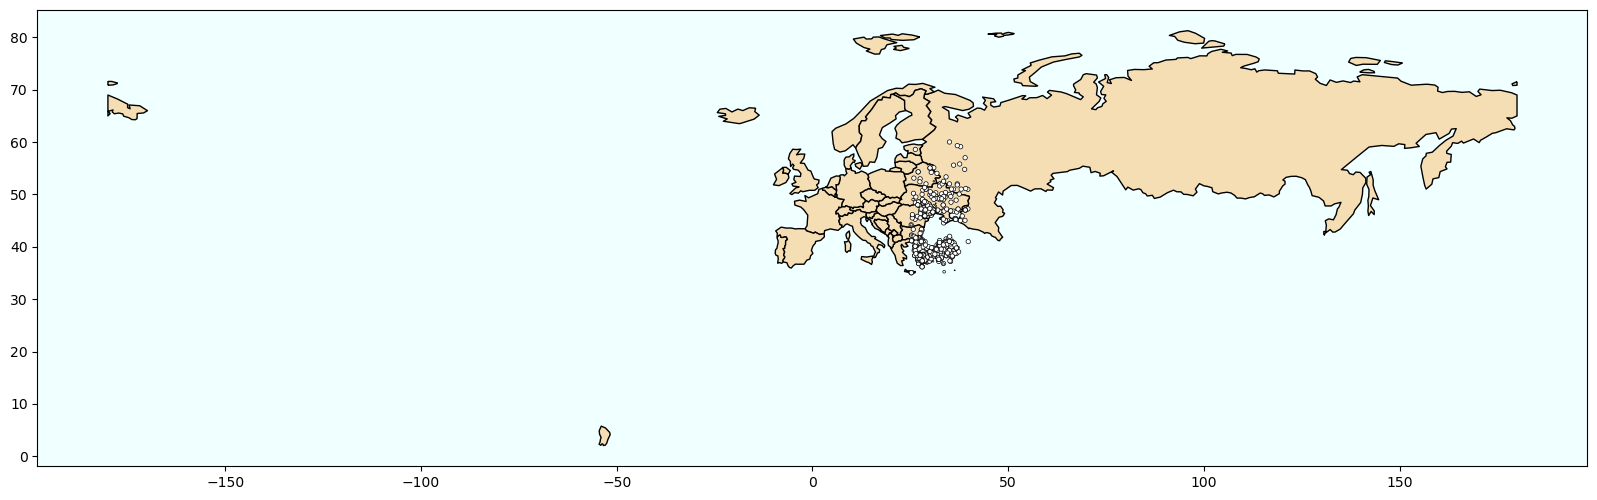

       LIDNUM       LONG        LAT  MN_TIME_UNIT  FIRST_OCC  ALL_OCC  \
388     23283  30.190000  38.189000            15          0        2   
390     23443  26.562000  38.614000            10          0        1   
391     23444  26.561000  38.596000            11          0        1   
407     28013  33.639167  35.228611            18          1        2   
493     28249  25.325125  42.199561            12          0        1   
...       ...        ...        ...           ...        ...      ...   
78826   21167  28.100000  49.033000            15          0        1   
79202   21142  30.000000  47.300000            11          0        1   
79203   21161  28.600000  48.600000            15          0        2   
79298   20222  32.917000  39.550000             7          0        1   
79359   22267  31.000000  49.050000            19          0        3   

       PROPORTION  AREA_TOTAL_OCC  AREA_FIRST_OCC  PREV_AREA_TOTAL  
388           0.0            19.0            10.0     

In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas
import numpy as np
import statsmodels.api as sm
import seaborn as sns
from scipy.stats import binom

# Exercise 2. Let's write a function that creates a dataframe from a txt file and converts it to csv.
def to_csv():
    dataframe = pd.read_csv("NOW_data.txt")
    save_as_csv = dataframe.to_csv("NOW_data.csv", index=None)
    return None

# Exercise 3. a) Cleaning the data. We will load the csv file, remove the unnecesary rows and return a cleaned dataset
def preprocessing():
    data = pd.read_csv("NOW_data.csv")
    data_new = data[(data["LAT"] != 0) & (data["LONG"]!= 0)]
    sp_indet = data_new[(data_new["SPECIES"] == "sp.") | (data_new["SPECIES"] == "Indet.")].index
    data_new = data_new.drop(sp_indet)
    return data_new

# Exercise 3. b) Let's create a function that will assign an MN time unit based on the mean age of an occurrence:
def find_mn(n):
    if 21.7 <= n <= 23:
        return "MN1"
    elif 19.5 <= n < 21.7:
        return "MN2"
    elif 17.2 <= n < 19.5:
        return "MN3"
    elif 16.4 <= n < 17.2:
        return "MN4"
    elif 14.2 <= n < 16.4:
        return "MN5"
    elif 12.85 <= n < 14.2:
        return "MN6"
    elif 11.2 <= n < 12.85:
        return "MN7-8"
    elif 9.9 <= n < 11.2:
        return "MN9"
    elif 8.9 <= n < 9.9:
        return "MN10"
    elif 7.6 <= n < 8.9:
        return "MN11"
    elif 7.1 <= n < 7.6:
        return "MN12"
    elif 5.3 <= n < 7.1:
        return "MN13"
    elif 5 <= n < 5.3:
        return "MN14"
    elif 3.55 <= n < 5:
        return "MN15"
    elif 2.5 <= n < 3.55:
        return "MN16"
    elif 1.9 <= n < 2.5:
        return "MN17"
    elif 0.85 <= n < 1.9:
        return "MQ18"
    elif 0.01 <= n < 0.85:
        return "MQ19"
    elif n < 0.01:
        return "pre-MN"
    else:
        return "post-MN"

# Exercise 3. b), c), d), e)
# Here we will save our previous dataset in a variable "data", 
# b) calculate the mean age of an occurrence based on the columns MIN_AGE and MAX_AGE,
# and apply our find_mn function to a new column ["MN_TIME_UNIT"]
# c) then we override the column ["MN_TIME_UNIT"] if the column ["NAME"] == "Samos Main Bone Beds" or "Can Llobateres 1"
# d) assign a unique ID to each unique combination of GENUS and SPECIES.
# e) we remove the duplicates, so that each locality contains no more than one occurrence of any species. 
def mn_time_unit():
    data = preprocessing()
    average_cols = data.loc[:, ["MIN_AGE", "MAX_AGE"]] # here we define the columns based on which we will calculate the mean
    data["AVERAGE"] = average_cols.mean(axis = 1)
    data["MN_TIME_UNIT"] = data["AVERAGE"].apply(find_mn)
    samos = data["NAME"]=="Samos Main Bone Beds" # here we find the indices of the rows where the name (locality) is Samos Main Bone Beds
    can = data["NAME"]=="Can Llobateres 1" # here we find the indices of the rows where the name (locality) is Can Llobateres 1
    data.loc[samos, "MN_TIME_UNIT"] = pd.Series(["MN12"] * samos.sum(), index = data.index[samos]) # here we override the MN_TIME_UNIT column for the rows in the variable samos
    data.loc[can, "MN_TIME_UNIT"] = pd.Series(["MN9"] * can.sum(), index = data.index[can]) # here we override the MN_TIME_UNIT column for the rows in the variable can

    # Let's drop the column "AVERAGE" that we created, as it is not in the assignment
    data = data.drop(["AVERAGE"], axis=1)
    data["SPECIES_ID"] = data.groupby(data[["SPECIES", "GENUS"]].apply(frozenset, axis=1)).ngroup() #here we group data by the unique combination of SPECIES and GENUS, assign a unique number to each group and add it to the new column SPECIES_ID
    # now we have 61561 rows x 104 columns

    # Let's drop duplicates based on the combination of "NAME" and "SPECIES_ID":
    result_df = data.drop_duplicates(subset=["NAME", "SPECIES_ID"]).reset_index(drop=True)
    unique_values = len(data.groupby(["NAME"])["SPECIES_ID"])
    return result_df
    # after dropping duplicates we have 61498 rows x 104 columns

    # f) from 61561 rows we got to 61498 rows, we have 7040 unique combinations of localities and species

# Exercise 4. Create a DataFrame that shows for each species how many
# occurrences it has in each time unit. Then, create a different DataFrame
# that shows for each species the time unit when it is first observed (i.e.
# the oldest time unit). For each time unit, calculate the proportion of first
# occurrences to all occurrences. Plot the proportion of first occurrences
# over time. Also, plot the total number of occurrences over time.
def occurences():
    data = mn_time_unit()
    occ_total = data[["LIDNUM", "NAME", "LONGSTR", "LAT", "LONG", "SPECIES", "GENUS", "MN_TIME_UNIT", "SPECIES_ID"]] # here we are just choosing the columns of the initial dataset to work with the smaller one
    occ_groups = occ_total.groupby(["SPECIES", "MN_TIME_UNIT"]).size() # here we create groups for each specie based on the time units and show how many times each time unit appears for each specie
    occ_time_unit = occ_groups.reset_index() # making a dataframe from the groups
    occ_num = occ_time_unit # saving similar dataframe in another variable as we will have to work with occ_time_unit again for plotting
    
    # because we will need to find the oldest time unit, let's change categorical names to numeric ones:
    occ_num["MN_TIME_UNIT"] = occ_time_unit["MN_TIME_UNIT"].replace(["pre-MN", "MN1", "MN2", "MN3", "MN4", "MN5", "MN6", "MN7-8", "MN9", "MN10", "MN11", "MN12", "MN13", "MN14", "MN15", "MN16", "MN17", "MQ18", "MQ19", "post-MN"], [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])
    occ_num["MN_TIME_UNIT"] = pd.to_numeric(occ_num["MN_TIME_UNIT"])

    # and now let's group by the min value in ["MN_TIME_UNIT"], create a dataframe from the group and then change the values in ["MN_TIME_UNIT"] back to initial ones:
    occ_min = occ_num.loc[occ_num.groupby(["SPECIES"])["MN_TIME_UNIT"].idxmin()].reset_index()
    occ_min["MN_TIME_UNIT"] = occ_min["MN_TIME_UNIT"].replace([0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], ["pre-MN", "MN1", "MN2", "MN3", "MN4", "MN5", "MN6", "MN7-8", "MN9", "MN10", "MN11", "MN12", "MN13", "MN14", "MN15", "MN16", "MN17", "MQ18", "MQ19", "post-MN"])
    occ_time_unit["MN_TIME_UNIT"] = occ_time_unit["MN_TIME_UNIT"].replace([0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], ["pre-MN", "MN1", "MN2", "MN3", "MN4", "MN5", "MN6", "MN7-8", "MN9", "MN10", "MN11", "MN12", "MN13", "MN14", "MN15", "MN16", "MN17", "MQ18", "MQ19", "post-MN"])
    occ_time_unit.rename(columns={0: "TOTAL_OCC"}, inplace=True)
    occ_min.rename(columns={0: "FIRST_OCC"}, inplace=True)
    # Let's create dataset where we will count all occurences of each MN_TIME_UNIT in the data and first occurences of each SPECIE:
    all_occ_df = data.value_counts("MN_TIME_UNIT").reset_index()
    first_occ_df = occ_min.value_counts("MN_TIME_UNIT").reset_index()
    first_occ_df.rename(columns={"count": "FIRST_OCC"}, inplace=True)
    all_occ_dict = all_occ_df.set_index("MN_TIME_UNIT").to_dict()['count']
    first_occ_df["ALL_OCC"] = first_occ_df["MN_TIME_UNIT"].map(all_occ_dict)
    # Let's calculate the proportion and add this value to a new column
    first_occ_df["PROPORTION"] = first_occ_df["FIRST_OCC"]/first_occ_df["ALL_OCC"]
    first_occ_df.set_index("MN_TIME_UNIT", inplace=True)
    first_occ_df = first_occ_df.reindex(["pre-MN", "MN1", "MN2", "MN3", "MN4", "MN5", "MN6", "MN7-8", "MN9", "MN10", "MN11", "MN12", "MN13", "MN14", "MN15", "MN16", "MN17", "MQ18", "MQ19", "post-MN"])
    first_occ_df = first_occ_df.reset_index()
    # And now let's plot the findings:
    fig, ax = plt.subplots(2, 1, figsize=(20, 20))
    ax1 = ax[0]
    ax2 = ax[1]
    ax1.plot(first_occ_df["MN_TIME_UNIT"], first_occ_df["PROPORTION"])
    ax2.plot(first_occ_df["MN_TIME_UNIT"], first_occ_df["ALL_OCC"])
    ax1.title.set_text("The proportion of first occurrences over time")
    ax1.title.set_size(20.0)
    ax2.title.set_text("Total number of occurrences over time")
    ax2.title.set_size(20.0)
    plt.xlabel("MN Time Units", fontsize=15.0)
    ax1.set_ylabel("Proportion", fontsize=15.0)
    ax2.set_ylabel("Number Of Occurences", fontsize=15.0)
    ax1.set_xticklabels(first_occ_df["MN_TIME_UNIT"], rotation=45)
    ax2.set_xticklabels(first_occ_df["MN_TIME_UNIT"], rotation=45)
    plt.show()
    return

# Exercise 5
# In this exercise we will do similar actions as in the previous exercise, with some adjustments:
# a) we will create a dataframe where we will copy a slice of an existing df
# we will group the data in 2 ways: 
# 1) by the ["SPECIES"]["MN_TIME_UNIT"].idxmin() and ["LIDNUM"]["SPECIES"] to find the number of first occurences in each locality
# 2) just by ["LIDNUM"]["SPECIES"] to find all occerences
# Then we will combine the initial dataset with two new columns and create a new column to calculate the proportion
# b) We will visualize the findings using geopandas
def locality_info():
    data = mn_time_unit()[["LIDNUM", "NAME", "LAT", "LONG", "SPECIES", "GENUS", "MN_TIME_UNIT", "SPECIES_ID"]] # copying the columns we will use
    # now we will replace categorical data in MN_TIME_UNIT with numeric one to find the first occurences:
    data["MN_TIME_UNIT"] = data["MN_TIME_UNIT"].replace(["pre-MN", "MN1", "MN2", "MN3", "MN4", "MN5", "MN6", "MN7-8", "MN9", "MN10", "MN11", "MN12", "MN13", "MN14", "MN15", "MN16", "MN17", "MQ18", "MQ19", "post-MN"], [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])
    min_tu_occ = data.loc[data.groupby(["SPECIES"])["MN_TIME_UNIT"].idxmin()].reset_index() # finding out the indices of min values in groups made by ["SPECIES"] and ["MN_TIME_UNIT"]
    first_occ = min_tu_occ.groupby(["LIDNUM"])["SPECIES"].size().reset_index() # finding out how the size of each group where species occur the first time in a unique locality
    all_occ = data.groupby(["LIDNUM"])["SPECIES"].size().reset_index() # finding out how the size of each group where species occur in a unique locality in general
    all_occ.rename(columns={"SPECIES": "ALL_OCC"}, inplace=True)
    first_occ.rename(columns={"SPECIES": "FIRST_OCC"}, inplace=True)
    data["MN_TIME_UNIT"] = data["MN_TIME_UNIT"].replace([0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], ["pre-MN", "MN1", "MN2", "MN3", "MN4", "MN5", "MN6", "MN7-8", "MN9", "MN10", "MN11", "MN12", "MN13", "MN14", "MN15", "MN16", "MN17", "MQ18", "MQ19", "post-MN"])
    result_df = data[["LIDNUM", "LONG", "LAT", "MN_TIME_UNIT"]] # making the final df
    result_df.drop_duplicates(subset=['LIDNUM'], keep="first", inplace=True) # leaving only unique LIDNUM values, now result_df has the same length as all_occ
    first_occ_dict = first_occ.set_index("LIDNUM").to_dict()['FIRST_OCC'] # converting first_occ to dict for mapping
    result_df["FIRST_OCC"] = result_df["LIDNUM"].map(first_occ_dict)
    result_df["FIRST_OCC"] = result_df["FIRST_OCC"].fillna(0) # first_occ is smaller than all_occ, because some localities had 0 first occurences. We will fill the NaN values with 0 so we can calculate the proportion
    result_df["FIRST_OCC"] = result_df["FIRST_OCC"].astype(int)
    all_occ_dict = all_occ.set_index("LIDNUM").to_dict()['ALL_OCC'] 
    result_df["ALL_OCC"] = result_df["LIDNUM"].map(all_occ_dict)
    result_df["PROPORTION"] = result_df["FIRST_OCC"]/result_df["ALL_OCC"] # creating the ["PROPORTION"] column and filling it with the ration between ["FIRST_OCC"] and ["ALL_OCC"]

    # Now let's create a map with geopandas:
    world = (geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres')))
    gdf = geopandas.GeoDataFrame(
        result_df, geometry=geopandas.points_from_xy(result_df.LONG, result_df.LAT), crs="EPSG:4326"
        ) # creating a dataframe where LONG and LAT will be converted to the coordinates
    fig , ax = plt.subplots(figsize=(20,10))
    world.plot(ax=ax, color='wheat', edgecolor='black')
    ax.set_facecolor('azure')
    # Now we can plot the markers:
    sizes = [x*1.25 for x in result_df.ALL_OCC]
    colors = []
    for x in sizes:
        if x < 10:
            colors.append("#ADCBA9")
        else:
            colors.append("#667763")
    ax.scatter(result_df.LONG, result_df.LAT, s=sizes, c=colors, edgecolors="black", linewidths=0.5)
    plt.show()
    return result_df

# Exercise 6.
# the following function will help us determine weather the point is within the 10 by 10 area with the center = (LAT, LONG) of each locality
# for this we will substract 5 from each coordinate to define min LAT and min LONG, and add 5 to find max LAT and max LONG
# then we will return the fraction of the dataframe with the occurences that fit the rectangle and match the time unit.
def in_rect(data, lat, lon, time_unit):
    min_lon = lon-5
    min_lat = lat-5
    max_lon = lon+5
    max_lat = lat+5
    result = data[(data["LAT"] >= min_lat) & (data["LAT"] <= max_lat) & (data["LONG"] >= min_lon) & (data["LONG"] <= max_lon) & (data["MN_TIME_UNIT"] == time_unit)]
    return result

def area_info():
    data = locality_info()
    data["MN_TIME_UNIT"] = data["MN_TIME_UNIT"].replace(["pre-MN", "MN1", "MN2", "MN3", "MN4", "MN5", "MN6", "MN7-8", "MN9", "MN10", "MN11", "MN12", "MN13", "MN14", "MN15", "MN16", "MN17", "MQ18", "MQ19", "post-MN"], [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])
    for index, row in data.iterrows():
        lat = row["LAT"]
        lon = row["LONG"]
        time_unit = row["MN_TIME_UNIT"]
        prev_time_unit = row["MN_TIME_UNIT"] - 1 # we are looping through each row in dataset, to collect the data for the above function
        occurences = in_rect(data, lat, lon, time_unit) 
        prev_occurences = in_rect(data, lat, lon, prev_time_unit)

        total_occ = len(occurences)
        first_occ = occurences["FIRST_OCC"].sum()
        prev_total_occ = len(prev_occurences)

        data.at[index, "AREA_TOTAL_OCC"] = total_occ #adding new columns:
        data.at[index, "AREA_FIRST_OCC"] = first_occ
        data.at[index, "PREV_AREA_TOTAL"] = prev_total_occ
    return data

# Exercise 7. a) b) c)
def log_regression():
    data = area_info()
    data["MN_TIME_UNIT"] = data["MN_TIME_UNIT"].replace(["pre-MN", "MN1", "MN2", "MN3", "MN4", "MN5", "MN6", "MN7-8", "MN9", "MN10", "MN11", "MN12", "MN13", "MN14", "MN15", "MN16", "MN17", "MQ18", "MQ19", "post-MN"], [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])
    # Let's cut the dataframe based on LONG and LAT, to choose only european occurences:
    europe = data.loc[(data["LONG"] > 25) & (data["LONG"] < 40) & (data["LAT"] > 35) & (data["MN_TIME_UNIT"] >=2) & (data["MN_TIME_UNIT"] <= 19)]
    regression_df = europe.loc[:, ["PREV_AREA_TOTAL","FIRST_OCC"]] # choosing 2 columns that will fit the regression model
    mask = regression_df["FIRST_OCC"] > 1
    regression_df.loc[mask, "FIRST_OCC"] = 1 # we need a binomial data, so we change all the FIRST_OCC > 1 to "1"
    X = regression_df.iloc[:, 0]
    X = sm.add_constant(X)
    y = regression_df.iloc[:, 1]
    model = sm.Logit(y, X)
    result = model.fit()
    summary = result.summary()
    coefficients = result.params
    confidence95 = result.conf_int(alpha=0.05)
    sns.regplot(x="PREV_AREA_TOTAL", y="FIRST_OCC", data=regression_df, logistic=True, ci=95) #plotting the logistic regression and and 95%-confidence intervals

    # Exercise 8. Now we will predict the proportions of of first occurrences in the focal area
    pred_df = europe.loc[:, ["PREV_AREA_TOTAL", "PROPORTION"]]
    ypred = result.predict(X)
    x_test = pred_df.iloc[:, 1]
    Xnew = sm.add_constant(x_test)
    ynewpred = result.predict(Xnew)
    #sns.regplot(x="PREV_AREA_TOTAL", y="PROPORTION", data=pred_df, logistic=True, ci=95)
    
    # Exercise 9. Now we need to calculate the probability of observing 
    # as many or more first occurrences in each locality in Europe
    new_data = europe.loc[:, ["PREV_AREA_TOTAL","FIRST_OCC", "PROPORTION"]] # we will be calculatiing probabilities based on these three columns
    all_probabilities = [] # here we will store all the probabilities
    for index, row in new_data.iterrows():
        p = binom.pmf(row["FIRST_OCC"], row["PREV_AREA_TOTAL"], row["PROPORTION"]) # we loop through new_data and count the probability with Probability mass function
        all_probabilities.append(p)
    new_data["PROBABILITIES"] = all_probabilities

    # Exercise 10.

    world = (geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))) # loading the world map
    europe_map = world[world.continent == "Europe"] # selecting the european area
    gdf = geopandas.GeoDataFrame(
        europe, geometry=geopandas.points_from_xy(europe.LONG, europe.LAT), crs=3035
        ) # creating a dataframe where LONG and LAT will be converted to the coordinates
    fig , ax = plt.subplots(figsize=(20,10))
    europe_map.plot(ax=ax, color='wheat', edgecolor='black')
    ax.set_facecolor('azure')
    # Now we can plot the markers:
    sizes = [x*10 for x in all_probabilities]
    colors = []
    for x in all_probabilities:
        if x < 0.05:
            colors.append("#667763")
        else:
            colors.append("white")
    ax.scatter(europe.LONG, europe.LAT, s=sizes, c=colors, edgecolors="black", linewidths=0.5)
    plt.show()
    # I don't get why the map looks so weird
    return europe


print(log_regression())